# Investigating Gaussian Processes for di-jet invariant mass fit function

In [307]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [308]:
import george
from george.kernels import ExpSquaredKernel, MyLocalGaussianKernel, ExpKernel, MyLocalExpSquared
from scipy.optimize import curve_fit
import triangle
from lmfit import Parameters, minimize, fit_report
import emcee
pl = plt

## Load data

In [309]:
# https://github.com/mfrate28/GuassianProcesses/blob/master/DijetsResiduals.ipynb
# originally from HEPdata
#np.savetxt('dijet_data.csv', (xval, xerrminus, xerrplus, yval, yerr, xerr))

In [310]:
#cut out first 24 bins b/c fits seem crazy there
xval, xerrminus, xerrplus, yval, yerr, xerr = np.loadtxt('dijet_data.csv', usecols=range(24,60))
#scale data by bin width since curve-fit can't have the model take in an argument
#newy = yval/(xerrplus+xerrminus) 

## Define standard CDF dijet fitting function

Notice that curve_fit is a least squares fit and minimize will minimize what is given, but residual_CDF2009 isn't a -logL

In [311]:
def model2_CDF2009(t, params): 
    global xerrplus, xerrminus
    p0, p1, p2, p3 = params
    sqrts = 8000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts)))*(xerrplus+xerrminus)

In [312]:
def nll(params, t,data=None): #gaussian distribution
    #prediction = p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2+p3*np.log(t/sqrts))
    prediction = model2_CDF2009(t,params.valuesdict().values() )
    return (prediction-data)/np.sqrt(prediction)

In [313]:
#initialize parameters
fit_params = Parameters()
fit_params.add('p0', value=0.0490546530927)
fit_params.add('p1', value=7.3087377889)
fit_params.add('p2', value=-6.00446454843)
fit_params.add('p3', value=0.1347386042)
#try a different set of parameter values
fit_params['p0'].value = 0.55765009832017132
fit_params['p1'].value = 8.6753672190427995
fit_params['p2'].value = -5.4038968232544793
fit_params['p3'].value = -0.042639640230075333
fit_params

Parameters([('p0', <Parameter 'p0', 0.5576500983201713, bounds=[-inf:inf]>), ('p1', <Parameter 'p1', 8.6753672190428, bounds=[-inf:inf]>), ('p2', <Parameter 'p2', -5.403896823254479, bounds=[-inf:inf]>), ('p3', <Parameter 'p3', -0.04263964023007533, bounds=[-inf:inf]>)])

('do fit', '[[Variables]]\n    p0:   0.55765009 (init= 0.04905465)\n    p1:   8.67536721 (init= 7.308738)\n    p2:  -5.40389682 (init=-6.004465)\n    p3:  -0.04263964 (init= 0.1347386)\n[[Correlations]] (unreported correlations are <  0.100)')


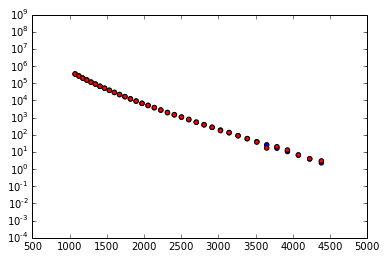

In [314]:
#do fit
out = minimize(nll, fit_params, args=(xval,), kws={'data':yval})

print("do fit", fit_report(fit_params))

plt.scatter(xval, model2_CDF2009(xval,  fit_params.valuesdict().values()))
plt.scatter(xval, yval, c='r')
plt.ylim([10e-5, 10e8])
plt.yscale('log')

(-100.0, 100.0)

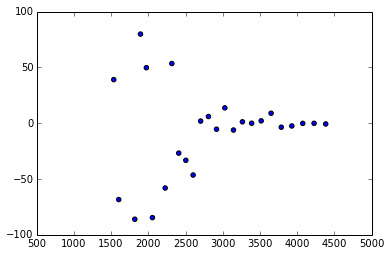

In [315]:
plt.scatter(xval, model2_CDF2009(xval,fit_params.valuesdict().values() )-yval) 
plt.ylim(-1E2,1E2)

## Do MCMC on the CDF fit function

In [316]:
def lnlike_ind(p, t, y, yerr):
    prediction = model2_CDF2009(t,p )
    return -0.5 * np.sum( (prediction-y)*(prediction-y) / prediction) 
    # return p1*math.log(1-t)+(p2+p3*math.log(t)

def lnprior_ind(p):
    p0, p1, p2, p3 = p
    if (0 < p0 < 3 and  0 < p1 < 10 and -10 < p2 < 0 and -1 < p3 < 1):
        return 0.0
    return -np.inf

def lnprob_ind(p, x, y, yerr): 
    lp = lnprior_ind(p) 
    return lp + lnlike_ind(p, x, y, yerr) if np.isfinite(lp) else -np.inf

In [317]:
def fit_ind(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_ind, args=data)
    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()
    
    best_fit = p0[np.argmax(lnp)]
    print best_fit

    #print("Running second burn-in")
    #p = p0[np.argmax(lnp)]
    #p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    #p0, _, _ = sampler.run_mcmc(p0, 500)
    #sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler, best_fit

In [318]:
np.random.seed(1234)
init_params = fit_params.valuesdict().values()
data = (xval, yval, np.sqrt(yval))

# Fit assuming GP.
print("Fitting ind")
sampler, best_fit = fit_ind(init_params, data)
samples = sampler.flatchain

Fitting ind
Running burn-in
[ 0.71428741  8.68705576 -5.12770767  0.03188366]
Running production


### Look at residuals for some sample curves from the posterior
kind of useless b/c big jumps come from fluctuation of data that no model can accomodate

(-1000, 1000)

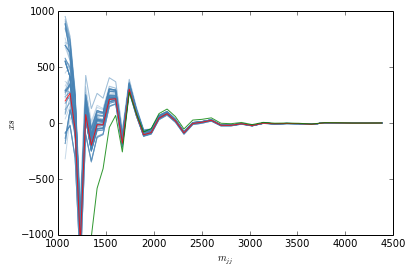

In [319]:
for s in samples[:100]:
    pl.plot(xval, yval-model2_CDF2009(xval,s), color="#4682b4", alpha=0.3)

pl.plot(xval, yval-model2_CDF2009(xval,p), color="r", alpha=0.8)
pl.plot(xval, yval-model2_CDF2009(xval,init_params), color="g", alpha=0.8)

pl.ylabel(r"$xs$")
pl.xlabel(r"$m_{jj}$")
pl.ylim(-1000,1000)


### look at spread about the best fit
more useful b/c it shows how the models vary

(-500, 200)

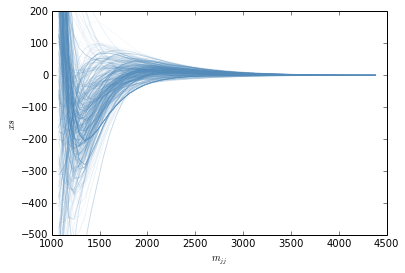

In [331]:
best_fit_model = model2_CDF2009(xval,best_fit)
for s in samples[:1000]:
    pl.plot(xval, best_fit_model-model2_CDF2009(xval,s), color="#4682b4", alpha=0.05)

pl.ylabel(r"$xs$")
pl.xlabel(r"$m_{jj}$")
pl.ylim(-500,200)

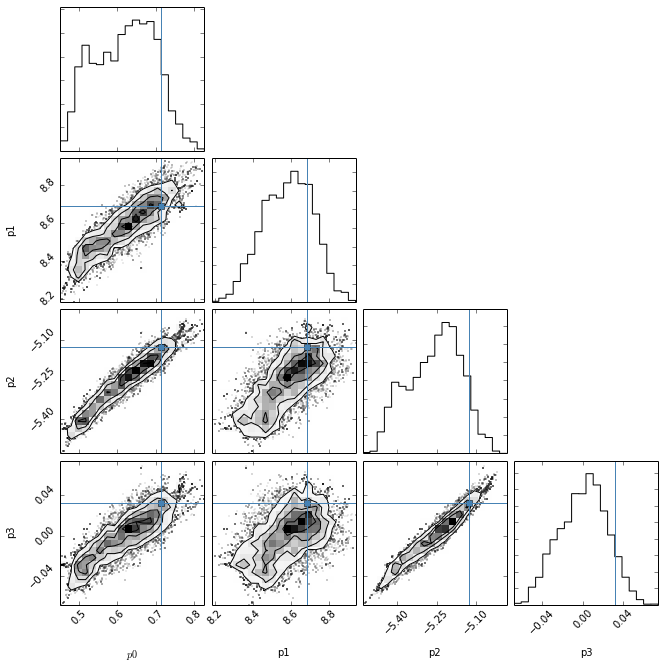

In [321]:
import corner
#p = [ 0.6797052,   8.64475999, -5.17048789,  0.02135271]
fig = corner.corner(samples, labels=["$p0$", "p1", "p2", "p3"],
                      truths=best_fit)

In [322]:
lnlike_ind(init_params,xval,yval, yval), lnlike_ind(best_fit,xval,yval, yval)

(-78.227968039392508, -19.438852752161459)

## Based on MCMC samples, build covariance and correlation matrix

In [323]:
modelMatrix=np.empty([samples.shape[0], xval.size])
for i,s in enumerate(samples):
    modelMatrix[i,:]= model2_CDF2009(xval,s)
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

[]

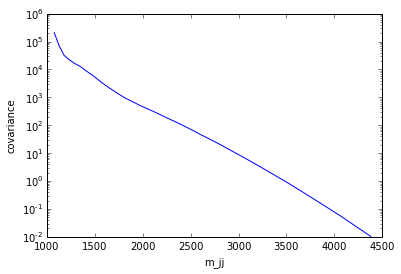

In [324]:
#Plot the variance vs. m_jj
plt.plot(xval,np.diagonal(covMat))
plt.ylabel('covariance')
plt.xlabel('m_jj')
plt.semilogy()

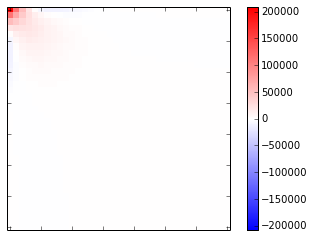

In [325]:
#plot covariance matrix
crop=0
maxVal = covMat[crop,crop]
plt.imshow(covMat[crop:,crop:], cmap="bwr",vmin=-maxVal, vmax=maxVal, interpolation="nearest")
plt.colorbar()
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([]);

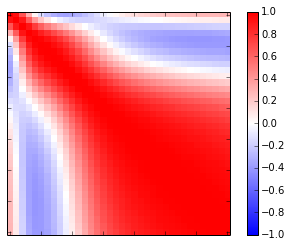

In [326]:
#plot correlation matrix
plt.imshow(corMat, cmap='bwr', vmin=-1, interpolation="nearest")
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.colorbar();

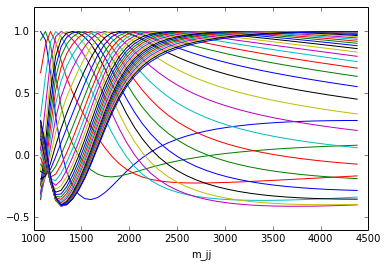

In [327]:
#plot values for rows of correlation vs. m_jj
for i in range(xval.size):
    plt.plot(xval,corMat[i,:])
plt.xlabel("m_jj");

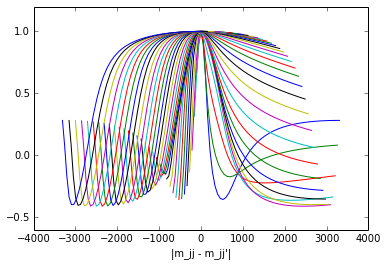

In [328]:
#plot correlation vs. |m_jj - m_jj'|
for i in range(xval.size):
    plt.plot(xval-xval[i],corMat[i,:])
plt.xlabel("|m_jj - m_jj'|");

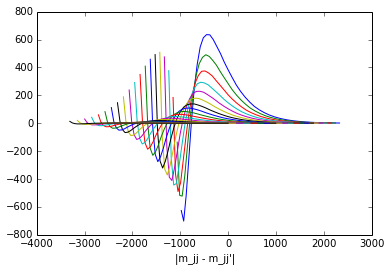

In [329]:
#plot covariance vs. |m_jj - m_jj'|, exclude the first ones that are huge
for i in range(15,xval.size):
    plt.plot(xval-xval[i],covMat[i,:])
plt.xlabel("|m_jj - m_jj'|");

## Model the covariance

#Try with Gaussian Process

In [332]:
import george
from george.kernels import ExpSquaredKernel, MyLocalGaussianKernel, ExpKernel, MyLocalExpSquared



In [ ]:
kernel = ExpSquaredKernel(1.0)